# Introduction

Notebook for training deep neural networks to estimate the compliance of an image to the MOUTH requisite.

The training is supervised and labels were obtained through the running of the MouthOpenface model followed by a Tagger execution
with a threshold of 0.1.

# Import Libraries and Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import cv2
import random
import numpy as np
import pandas as pd

from imutils import paths

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


if '../../../notebooks/' not in sys.path:
    sys.path.append('../../../notebooks/')

import utils.constants as cts
import utils.draw_utils as dr

from models.oface_mouth_model import OpenfaceMouth

from data_loaders.fvc_pyb_loader import FvcPybossaDL
from data_loaders.vgg_loader import VggFace2DL
from data_loaders.caltech_loader import CaltechDL
from data_loaders.cvl_loader import CvlDL
from data_loaders.colorferet_loader import ColorFeretDL
from data_loaders.fei_loader import FeiDB_DL
from data_loaders.gtech_loader import GeorgiaTechDL
from data_loaders.uni_essex_loader import UniEssexDL
from data_loaders.icpr04_loader import ICPR04_DL
from data_loaders.imfdb_loader import IMFDB_DL
from data_loaders.ijbc_loader import IJBC_DL
from data_loaders.lfw_loader import LFWDL
from data_loaders.celeba_loader import CelebA_DL
from data_loaders.casia_webface_loader import CasiaWebface_DL

from gt_loaders.gen_gt import Eval
from gt_loaders.fvc_gt import FVC_GTLoader
from gt_loaders.pybossa_gt import PybossaGTLoader

from tagger.tagger import Tagger

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
    raise Exception("Invalid device or cannot modify virtual devices once initialized.")


# Load Data and Labels

In [4]:
m = OpenfaceMouth()

req = cts.ICAO_REQ.MOUTH

dl_list = [FvcPybossaDL(aligned=False), FvcPybossaDL(aligned=True),
           CaltechDL(aligned=False), 
           VggFace2DL(aligned=False), VggFace2DL(aligned=True),
           CvlDL(aligned=False), 
           ColorFeretDL(aligned=False), 
           FeiDB_DL(aligned=False), FeiDB_DL(aligned=True),
           CvlDL(aligned=False), 
           GeorgiaTechDL(aligned=False), GeorgiaTechDL(aligned=True), 
           UniEssexDL(aligned=False),
           UniEssexDL(aligned=False), 
           ICPR04_DL(aligned=False), 
           IMFDB_DL(aligned=True),
           IJBC_DL(aligned=False),
           LFWDL(aligned=False), LFWDL(aligned=True), 
           CelebA_DL(aligned=True),
           CasiaWebface_DL(aligned=False)
          ]

in_data = pd.DataFrame(columns=['origin','img_name','comp'])

for dl in dl_list:
    t = Tagger(dl, m, req)
    t.load_labels_df()
    tmp_df = t.labels_df
    tmp_df['origin'] = dl.get_name().value
    tmp_df['aligned'] = dl.is_aligned()
    in_data = in_data.append(tmp_df)

in_data.shape    

(54363, 4)

# Network Training

## Data Selection and Preprocessing

In [24]:
data = []
labels = []

in_data = in_data[(in_data.origin == dl_list[0].get_name().value) & \
                  (in_data.aligned == True)]

for img_path,label in zip(in_data.img_name,in_data.comp):
	image = load_img(img_path, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)
	labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

print(data.shape, labels.shape)

(5780, 224, 224, 3) (5780,)


## Training

In [25]:
INIT_LR = 1e-4
EPOCHS = 40
BS = 32  

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/40
144/144 [==============================] - 32s 221ms/step - loss: 0.7597 - accuracy: 0.5198 - val_loss: 0.6984 - val_accuracy: 0.5458
Epoch 2/40
144/144 [==============================] - 33s 227ms/step - loss: 0.6988 - accuracy: 0.4708 - val_loss: 0.6948 - val_accuracy: 0.5528
Epoch 3/40
144/144 [==============================] - 47s 325ms/step - loss: 0.6950 - accuracy: 0.4980 - val_loss: 0.6940 - val_accuracy: 0.5337
Epoch 4/40
144/144 [==============================] - 41s 285ms/step - loss: 0.6941 - accuracy: 0.5157 - val_loss: 0.6937 - val_accuracy: 0.5597
Epoch 5/40
144/144 [==============================] - 38s 265ms/step - loss: 0.6937 - accuracy: 0.5438 - val_loss: 0.6935 - val_accuracy: 0.5389
Epoch 6/40
144/144 [==============================] - 31s 215ms/step - loss: 0.6936 - accuracy: 0.5514 - val_loss: 0.6934 - val_accuracy: 0.5415
Epoch 7/40
144/144 [==============================] - 31s 216ms/step - loss: 0.6

## Testing Trained Model

In [29]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY, predIdxs, target_names=['NON_COMP','COMP']))

[INFO] evaluating network...
              precision    recall  f1-score   support

    NON_COMP       0.23      0.33      0.27       242
        COMP       0.80      0.70      0.74       914

    accuracy                           0.62      1156
   macro avg       0.51      0.52      0.51      1156
weighted avg       0.68      0.62      0.65      1156



## Saving Model

In [30]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model.h5", save_format="h5")

[INFO] saving mask detector model...


## Plot Training Curves

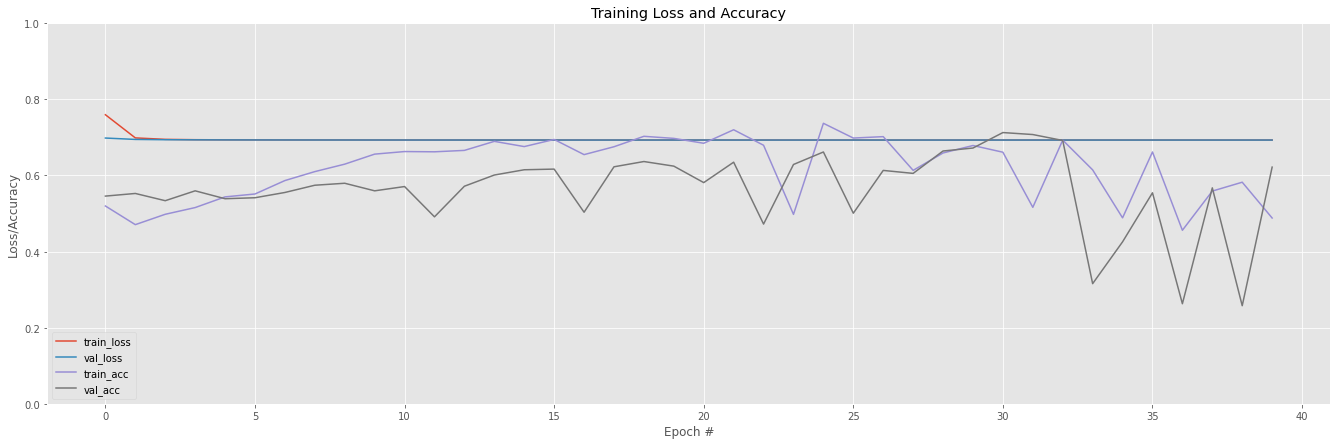

In [36]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(23,7))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.ylim([0,1])
plt.legend(loc="lower left")
plt.savefig("train.png")